<a id="top"></a>
# WFC3/UVIS Pixel Area Map Corrections for Subarrays


***
## Learning Goals

By the end of this tutorial, you will:

Learn how to implement pixel area map corrections on UVIS subarray images:
- 512 x 512 pixels
- 1024 x 1024 pixels
- 2048 x 2048 pixels

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Data](#main) <br>
- [2.1 Download Subarray Images](#load) <br>
- [2.2 WFC3 File Information](#file) <br>

[3. Determining the "Size" of the Data Image](#ex) <br>
[4. Downloading the Correct Pixel Area Map](#pam) <br>
- [4.1 Download PAM Files from the WFC3 Website](#PAMload) <br>
- [4.2 Perform PAM Corrections](#correct) <br>

[5. Putting It All Together ](#function) <br>
[6. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>


The WFC3/UVIS CCDs contain pixels that vary in their area on the sky as a result of the geometric distortion. Some pixels are larger and others are smaller. This means that there will be an overall gradient in an image of an intrinsically uniform background, because a larger pixel will collect more photons relative to a smaller one. 

The flat-fielding process in the HST [calwf3](https://wfc3tools.readthedocs.io/en/latest/wfc3tools/calwf3.html) pipeline is designed to correct for that gradient and produce images that have a flat background. As a result, while surface photometry measurements on flat-fielded science data (FLT) will be correct, the measured total brightness of sources will vary depending on the position of the object i.e. the areas of the pixels underlying the source. 

To achieve uniform aperture photometry of point sources across the detector, observers may either use FLT or FLC (charge transfer efficiency, or CTE, corrected) images, corrected by a pixel area map (PAM), or distortion-free drizzled (DRZ) images (see WFC3 [Pixel Area Maps](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/pixel-area-maps) for more information). 

Photometry measured on a calibration pipeline (FLT or FLC) image requires a field-dependent correction factor to achieve uniformity in the measured count rate of an object across the field. This correction, in the form of an image, is called the Pixel Area Map (PAM) (see the [WFC3 ISR 2010-08 on PAMs](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2010/WFC3-2010-08.pdf).) The size of the PAM image is the same as the calibrated (FLT or FLC) image and each pixel value is set to the normalized area of that pixel.

In this tutorial, we will walk through the process of applying PAM corrections to FLT images. The process is the same for FLC images. 





## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:
    
- *numpy* for handling array functions
- *astropy.io fits* for accessing FITS files
- *astroquery* for downloading data from MAST
- *matplotlib.pyplot* for plotting data
- *ginga* for finding min/max outlier pixels
- *urlib* for downloading files from a webpage

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from astropy.io import fits
from astroquery.mast import Observations
from ginga.util.zscale import zscale

## 2. Downloading Data <a id="main"></a>

Throughout this notebook, we will walk through the steps of applying pixel area map corrections to images taken in 3 different UVIS subarrays:
- 512 x 512 pixels
- 1024 x 1024 pixels
- 2048 x 2048 pixels

### 2.1 Download Subarray Images <a id="load"></a>

Here, we will download example images to use in this tutorial. These would be replaced with your own images, in practice. 

Let's query the data using MAST.

In [2]:
subarray512x512_Obs = Observations.query_criteria(obs_id='ICJD05SAQ')
subarray512x512_Prods = Observations.get_product_list(subarray512x512_Obs)
yourProd_512 = Observations.filter_products(subarray512x512_Prods, extension=["_flt.fits"])

In [3]:
subarray1024x1024_Obs = Observations.query_criteria(obs_id='ICW201020')
subarray1024x1024_Prods = Observations.get_product_list(subarray1024x1024_Obs)
yourProd_1024 = Observations.filter_products(subarray1024x1024_Prods, extension=["_flt.fits"])

In [4]:
subarray2048x2048_Obs = Observations.query_criteria(obs_id='ICHZ02AYQ')
subarray2048x2048_Prods = Observations.get_product_list(subarray2048x2048_Obs)
yourProd_2048 = Observations.filter_products(subarray2048x2048_Prods, extension=["_flt.fits"])

In [5]:
yourProd_512

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str9,str64,str1,str40,str9,str28,str8,str1,str6,str19,str5,str23,int64,str8,str6,int64
23954059,HST,image,icjd05saq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icjd05saq_flt.fits,SCIENCE,Minimum Recommended Products,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13716,icjd05saq_flt.fits,2992320,23954059,PUBLIC,2


In [6]:
yourProd_1024

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str37,str64,str1,str69,str9,str28,str11,str1,str7,str19,str5,str52,int64,str8,str6,int64
25014673,HST,image,icw201ciq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icw201ciq_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),14068,icw201ciq_flt.fits,10808640,25015061,PUBLIC,2
25014674,HST,image,icw201d6q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icw201d6q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),14068,icw201d6q_flt.fits,10808640,25015061,PUBLIC,2
25014675,HST,image,icw201d8q,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/icw201d8q_flt.fits,SCIENCE,--,FLT,--,CALWF3,3.7.1 (Oct-18-2023),14068,icw201d8q_flt.fits,10808640,25015061,PUBLIC,2


In [7]:
yourProd_2048

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str9,str64,str1,str40,str9,str28,str8,str1,str6,str19,str5,str23,int64,str8,str6,int64
23951956,HST,image,ichz02ayq,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,S,mast:HST/product/ichz02ayq_flt.fits,SCIENCE,Minimum Recommended Products,FLT,--,CALWF3,3.7.1 (Oct-18-2023),13620,ichz02ayq_flt.fits,42281280,23951956,PUBLIC,2


Now we can download our data.

In [8]:
Download_512 = Observations.download_products(yourProd_512, mrp_only=False, cache=False)

 [Done]


In [9]:
Download_1024 = Observations.download_products(yourProd_1024, mrp_only=False, cache=False)

 [Done]


 [Done]


 [Done]


In [10]:
Download_2048 = Observations.download_products(yourProd_2048, mrp_only=False, cache=False)

 [Done]


### 2.2 WFC3 File Information <a id="file"></a>

Below are some potentially helpful diagrams of WFC3/UVIS image file information:

WFC3/UVIS Data Structure


![WFC3/UVIS](uvis_data_format.png "uvis")


WFC3/UVIS Subarray Diagram 


![WFC3/UVIS/Subarray](UVIS_Subarrays.jpg)



## 3. Determining the "Size" of the Data Image <a id="ex"></a>


First, let's retrieve our data and headers using `astropy.io.fits()`. 
We start by opening the FLT file and reviewing the data structure:

In [11]:
file_loc_512 = 'mastDownload/HST/icjd05saq/icjd05saq_flt.fits'
hdu_512 = fits.open(file_loc_512)
hdu_512.info()

Filename: mastDownload/HST/icjd05saq/icjd05saq_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     299   ()      
  1  SCI           1 ImageHDU       196   (513, 512)   float32   
  2  ERR           1 ImageHDU        48   (513, 512)   float32   
  3  DQ            1 ImageHDU        40   (513, 512)   int16   
  4  HDRLET        1 NonstandardExtHDU     21   (57600,)      
  5  HDRLET        2 NonstandardExtHDU     17   (5760,)      
  6  HDRLET        3 NonstandardExtHDU     21   (57600,)      
  7  HDRLET        4 NonstandardExtHDU     21   (57600,)      
  8  WCSCORR       1 BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   
  9  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
 10  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
 11  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
 12  D2IMARR       2 ImageHDU        15   (6

We need the science data and the science header. We view the data and print the first 10 lines of each to peek at their contents:

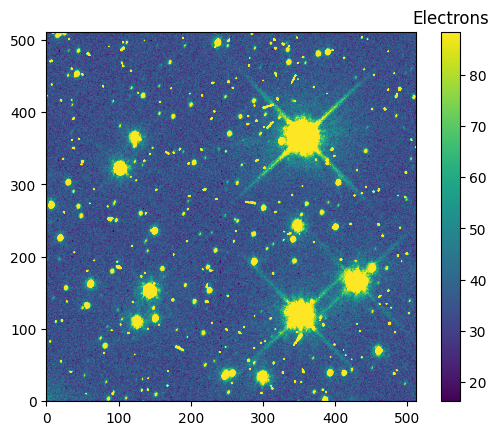

In [12]:
data_512 = hdu_512[1].data

# We use zcale to find the min and max for plotting
vmin_512, vmax_512 = zscale(data_512)

im = plt.imshow(data_512, vmin=vmin_512, vmax=vmax_512, origin='lower')
clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

In [13]:
scihdr_512 = hdu_512[1].header
scihdr_512[0:10]

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  513 / length of data axis 1                          
NAXIS2  =                  512 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2023-12-16' / date this file was written (yyyy-mm-dd)                
INHERIT =                    T / inherit the primary header                     

To determine what units our science data is in, we can check the "BUNIT" key word of the science header.

In [14]:
scihdr_512['BUNIT']

'ELECTRONS'

Now, to define the subarray coordinates that we will 'cut' out of the Pixel Area Map, we look at certain keywords.\
Namely, we look at:
- scihdr['LTV1']: 'offset in X to subsection start' 

- scihdr['LTV2']: 'offset in Y to subsection start'

- scihdr['NAXIS1']: 'length of data axis 1'

- scihdr['NAXIS2']: 'length of data axis 2'

These define the x and y pixel coordinates of the four corners of the science image.

In [15]:
x0 = int(np.abs(scihdr_512['LTV1']))
y0 = int(np.abs(scihdr_512['LTV2']))
x1 = int(x0 + scihdr_512['NAXIS1'])
y1 = int(y0 + scihdr_512['NAXIS2'])

print(f'(x0, y0, x1, y1) = ({x0}, {y0}, {x1}, {y1})')

(x0, y0, x1, y1) = (0, 1, 513, 513)


## 4. Downloading the Correct Pixel Area Map<a id="pam"></a>

### 4.1 Download PAM Files from the WFC3 Website <a id="PAMload"></a>

The UVIS CCD has two chips: UVIS1 and UVIS2. We will download the UVIS1 and UVIS2 PAMs from the [WFC3 PAM website](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/pixel-area-maps).

In [16]:
filenames = ["UVIS1wfc3_map.fits", "UVIS2wfc3_map.fits"]

try:
    for filename in filenames:
        url = ("https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/" + 
               "wfc3/data-analysis/pixel-area-maps/_documents/")
        url += filename

        with urllib.request.urlopen(url) as response:
            with open(filename, "wb") as out_file:
                out_file.write(response.read())

except Exception as e:
    print(f"An error occured: {e}")

Now, we should have our WFC3/UVIS PAM files in our working directory.

### 4.2 Perform PAM Corrections <a id="correct"></a>


We search the science header (scihdr) for the 'CCDCHIP' keyword to determine whether our subarray is on UVIS1 or UVIS2 (see WFC3 UVIS Subarray Diagram // [figure 6.2 in the WFC Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-4-uvis-field-geometry)).

The PAM corrected data would be the product of the original data and the pixel area map (cut to the correct pixel dimensions). 

In [17]:
if scihdr_512['CCDCHIP'] == 1:
    pam = fits.getdata('UVIS1wfc3_map.fits')
    pamcorr_data_512 = data_512 * pam[y0:y1, x0:x1]

elif scihdr_512['CCDCHIP'] == 2:
    pam = fits.getdata('UVIS2wfc3_map.fits')
    pamcorr_data_512 = data_512 * pam[y0:y1, x0:x1]
else:
    raise Exception('Chip case not handled.')

We now have pamcorr_data, our pixel area map corrected FLT image data! We can see the difference between the original image and tha pamcorr image below. 

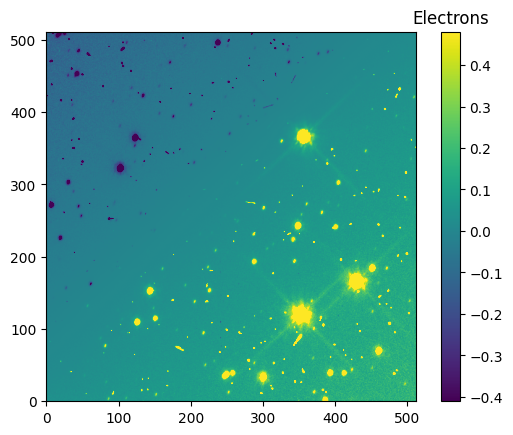

In [18]:
diff_data_512 = (pamcorr_data_512 - data_512)

# We use zcale to find the min and max for plotting
vmin_diff_512, vmax_diff_512 = zscale(diff_data_512)

im = plt.imshow(diff_data_512, vmin=vmin_diff_512, vmax=vmax_diff_512, origin='lower')

clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

## 5. Putting It All Together <a id="function"></a>

Now that we have worked through applying PAM corrections step by step, we apply these corrections to our next two subarrays using a function combining all the steps. 

In [19]:
def make_PAMcorr_image_UVIS(data, scihdr, pamdir):
    """
    Corrects the geometric distortion of the input image
    data by multiplying by the correct UVIS PAM.
    Parameters
    ----------
    data : array
        Image data before correction.
    scihdr : header
        Header from science extension of data.
    pamdir : str
        Path to where pixel area maps for UVIS1 and/or
        UVIS2 are located.
    Returns
    -------
    pamcorr_data : array
        PAM-corrected data.
    """
    data = np.copy(data)
    x0 = int(np.abs(scihdr['LTV1']))
    y0 = int(np.abs(scihdr['LTV2']))
    x1 = int(x0 + scihdr['NAXIS1'])
    y1 = int(y0 + scihdr['NAXIS2'])
    
    if scihdr['CCDCHIP'] == 1:
        pam = fits.getdata(pamdir + 'UVIS1wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]

    elif scihdr['CCDCHIP'] == 2:
        pam = fits.getdata(pamdir + 'UVIS2wfc3_map.fits')
        pamcorr_data = data * pam[y0:y1, x0:x1]
    else:
        raise Exception('Chip case not handled.')

    return pamcorr_data

First, we will implement pixel area map corrections on the 1024x1024 subarray image.

In [20]:
file_loc_1024 = 'mastDownload/HST/icw201ciq/icw201ciq_flt.fits'
hdu_1024 = fits.open(file_loc_1024)
data_1024 = hdu_1024[1].data
scihdr_1024 = hdu_1024[1].header

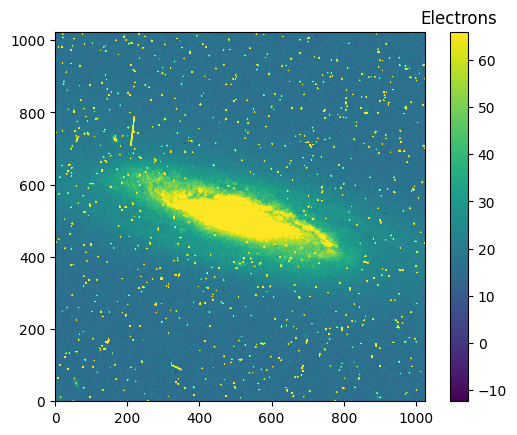

In [21]:
# We use zcale to find the min and max for plotting
vmin_1024, vmax_1024 = zscale(data_1024)

im = plt.imshow(data_1024, vmin=vmin_1024, vmax=vmax_1024, origin='lower')
clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

In [22]:
pamcorr_data_1024 = make_PAMcorr_image_UVIS(data=data_1024, scihdr=scihdr_1024, pamdir='')

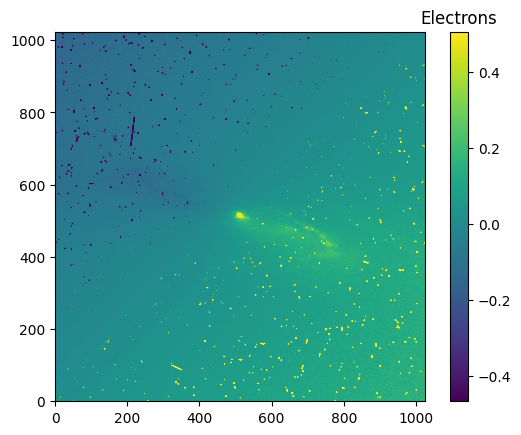

In [23]:
diff_data_1024 = (pamcorr_data_1024-data_1024)

# We use zcale to find the min and max for plotting
vmin_diff_1024, vmax_diff_1024 = zscale(diff_data_1024)

im = plt.imshow(diff_data_1024, vmin=vmin_diff_1024, vmax=vmax_diff_1024, origin='lower')

clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

Finally, we will apply the pixel area map corrections to the 2048x2048 subarray image.

In [24]:
file_loc_2048 = 'mastDownload/HST/ichz02ayq/ichz02ayq_flt.fits'
hdu_2048 = fits.open(file_loc_2048)
data_2048 = hdu_2048[1].data
scihdr_2048 = hdu_2048[1].header

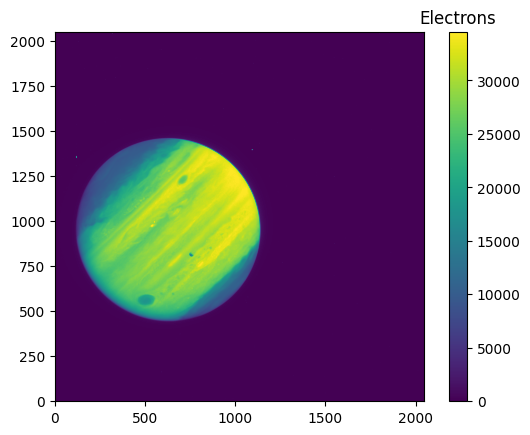

In [25]:
# We use zcale to find the min and max for plotting
vmin_2048, vmax_2048 = zscale(data_2048)

im = plt.imshow(data_2048, vmin=vmin_2048, vmax=vmax_2048, origin='lower')
clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

In [26]:
pamcorr_data_2048 = make_PAMcorr_image_UVIS(data=data_2048, scihdr=scihdr_2048, pamdir='')

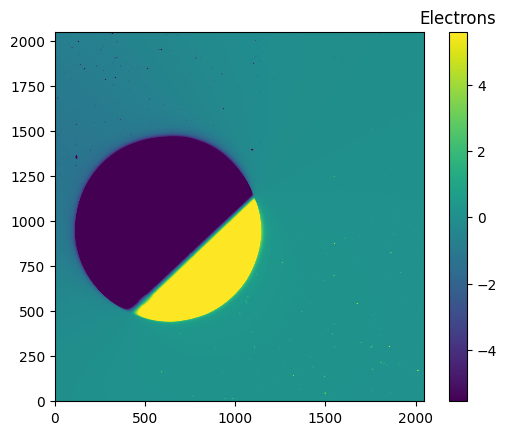

In [27]:
diff_data_2048 = (pamcorr_data_2048-data_2048)

# We use zcale to find the min and max for plotting
vmin_diff_2048, vmax_diff_2048 = zscale(diff_data_2048)

im = plt.imshow(diff_data_2048, vmin=vmin_diff_2048, vmax=vmax_diff_2048, origin='lower')

clb = plt.colorbar(im)
_ = clb.ax.set_title('Electrons')

## 6.  Conclusions <a id="conclusions"></a>

Thank you for walking through this notebook. Now with WFC3/UVIS data, you should be familiar with:

- Downloading image data.
- Downloading the Pixel Area Maps.
- "Cutting" the correct subarray out of the PAM image.
- Applying the pixel corrections to the data image.

**Congratulations, you have completed the notebook.**

## Additional Resources <a id="add"></a>

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)


## About this Notebook <a id="about"></a>


**Authors:** 
Anne O'Connor 2022 (notebook), 

Mariarosa Marinelli 2022 (code),

& Clare Shanahan 2019 (code), 

WFC3 Instrument 


**Updated On:** 2023-01-25

## Citations <a id="cite"></a>

If you use `numpy` or `astropy` for published research, please cite the
authors. Follow these links for more information about citing `numpy` and
`astropy`:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 